In [1]:
%load_ext autoreload
%autoreload 2

## test EY mapping of all US locations

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvcircuit as pvc
import ipywidgets as widgets
%matplotlib widget

Tandems version 0.989
Data path is:  /Users/jgeisz/opt/anaconda3/envs/pvdev/lib/python3.9/site-packages/tandems/data/


In [3]:
#load borders
path = pvc.datapath
file = 'USA_borders.csv'
dfBorders  = pd.read_csv(path+file, index_col=False, header=0)

#import EQE of WB417
file = 'WB417n6_C_EQE.csv'
df2J = pd.read_csv(path+file, index_col=0)
WB417_EQE = df2J.to_numpy(dtype=np.float64, copy=True) #numpy.ndarray
WB417_xEQE = df2J.index.to_numpy(dtype=np.float64, copy=True) #numpy.ndarray
EQE2J = pvc.EQE(WB417_EQE, WB417_xEQE, 'WB417_EQE')  #EQE class
EQE2J.sjuncs = ['GaInP','GaAs']  #rename junctions

#models of WB417
dev3T = pvc.Tandem3T()
dev3T.set(name='WB417dev3T', Rz = 2.3)
dev3T.top.set(Eg=1.87, J0ratio=[ 80., 22.], Jext=0.0131, Gsh=1e-8)   
dev3T.bot.set(Eg=1.419, J0ratio=[10., 15.], Jext=0.0128, Gsh= 5e-5)
dev3T.bot.set(Rser=0.2, beta=5, area=0.89)
dev2T = pvc.Multi2T.copy3T(dev3T)

In [4]:
#load TMY at each location
USAaxis = [] # list of TMY at different locations
nloc = len(pvc.EY.clst_axis)
#nloc = 10
for i in range(nloc):
    USAaxis.append(pvc.TMY(i)) #add another TMY to the list
    #print(i,USAaxis[i].name)

In [5]:
loc = []
model = dev3T
oper = 'CM'
ncells = 60
bot, top, ratio, type3T= pvc.EY.cellmodeldesc(model,oper)
loss = pvc.EY.VMloss(type3T, bot, top, ncells)
i=0
TMY=USAaxis[0]
for i, TMY in enumerate(USAaxis):
    TMY.cellbandgaps(EQE2J, 25)
    if i == 0: #only need to do the STC once
        TMY.cellcurrents(EQE2J, STC=True) #calculate currents at each location and spectrum
        STCeff = TMY.cellSTCeff(model,oper)

    TMY.cellcurrents(EQE2J) #calculate currents at each location and spectrum
    EY, EYeff = TMY.cellEYeff(model,oper)
    loc.append([TMY.longitude, TMY.latitude, TMY.altitude, TMY.YearlyEnergy, EY, EYeff, STCeff])
    
nploc = np.array(loc)

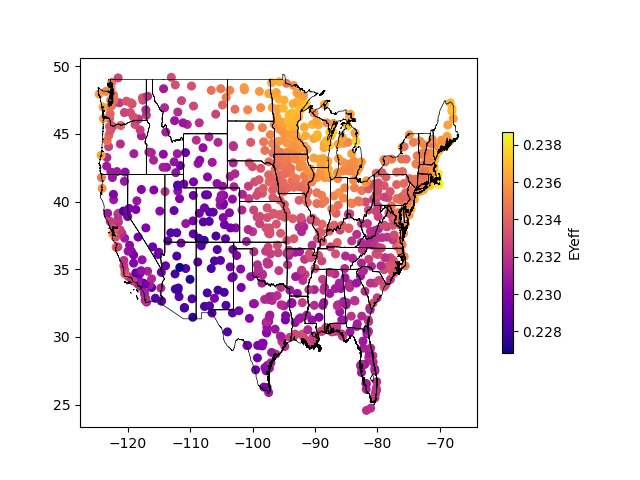

In [6]:
cmap='terrain'
cmap='plasma'
fig, ax = plt.subplots()
ax.plot(dfBorders['longitude'], dfBorders['latitude'],lw=0.5, color='black')
im = ax.scatter(nploc[:,0], nploc[:,1], marker='o', s=30, c=nploc[:,5], cmap=cmap)
cb = plt.colorbar(im, ax=ax, shrink=0.6, label='EYeff')

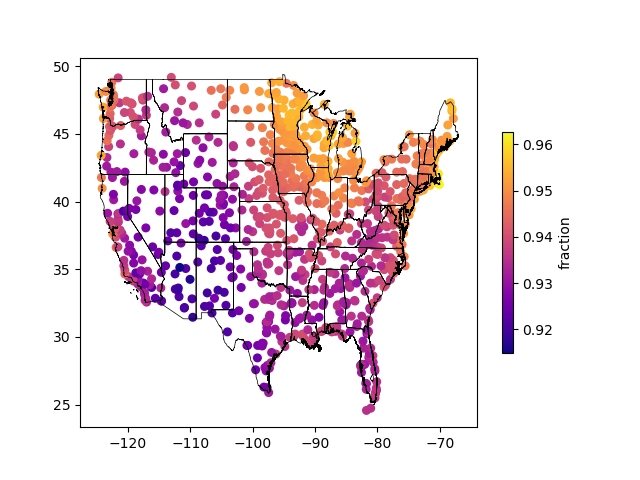

In [7]:
ffig, fax = plt.subplots()
fax.plot(dfBorders['longitude'], dfBorders['latitude'],lw=0.5, color='black')
fim = fax.scatter(nploc[:,0], nploc[:,1], marker='o', s=30, c=(nploc[:,5]/nploc[:,6]), cmap=cmap)
fcb = plt.colorbar(fim, ax=fax, shrink=0.6, label='fraction')

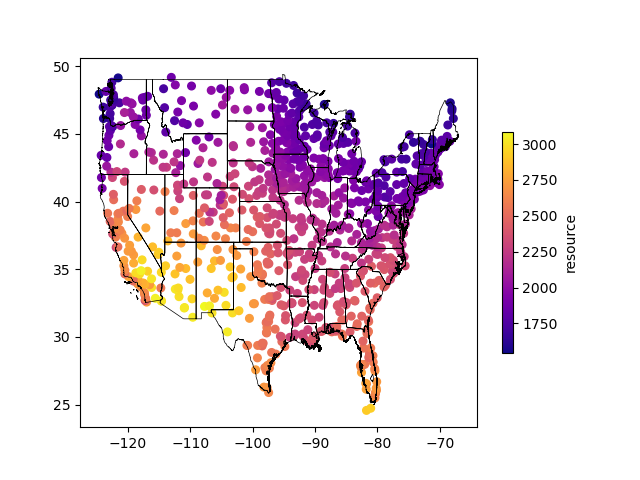

In [8]:
rfig, rax = plt.subplots()
rax.plot(dfBorders['longitude'], dfBorders['latitude'],lw=0.5, color='black')
rim = rax.scatter(nploc[:,0], nploc[:,1], marker='o', s=30, c=(nploc[:,3]), cmap=cmap)
rcb = plt.colorbar(rim, ax=rax, shrink=0.6, label='resource')